In [6]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
from geopandas import GeoDataFrame, GeoSeries
from osmnx import io
import glob

project_crs = 'epsg:3857'
from sklearn.cluster import DBSCAN
from shapely.geometry import Polygon, Point, LineString, MultiPolygon, MultiPoint
import math
import warnings
import pandas as pd
import shutil
from tqdm import tqdm
import time
warnings.filterwarnings(action='ignore')
from momepy import remove_false_nodes,extend_lines
pjr_loc = os.path.dirname(os.getcwd())
import ast # to convert str with list to list of string


<span style="color: Green;font-size: 30px">Module 1:Preliminary work</span>
<ul> <li>Download data from OpenStreetMap, project it, and convert it to a GeoDataFrame. OSMnx automatically resolves topology errors and retrieves only the street-related polylines.</li>
 <li>Identify roundabout elements, if any exist, and store them in a separate DataFrame.</li>
  <li>Remove additional irrelevant line objects based on values of the OSM 'tunnel' and 'highway' keys.</li>
   <li>Eliminate polylines that lack a name and calculate angles ranging from 0 to 180 degrees based on the bearing field.</li>
   </ul>


<span style="color: Red;font-size: 30px">Module 2 -3:Detect  parallel streets segments and merge them </span>
<ul> <li>For each group of streets with the same name search for parallel segments</li>
 <li> Use DBSCAN to classify streets based on their angle, and group each class. Outliers could not consider parallel with any street, thus removed</li>
  <li>The parallel test is on street segments that  have the same name and belong to the same angle group.
    <ul><li>Eliminate polylines that lack a name and calculate angles ranging from 0 to 180 degrees based on the bearing field.</li></ul>
    </li>

   </ul>

In [141]:
gdfs_to_save={}
# In this example, the data is extracted from OSM by specifying a location's name, but you can also download data using a specified polygon. The code is designed to handle multiple polygons or location names seamlessly.

# Download data from OpenStreetMap, project it, and convert it to a GeoDataFrame. OSMnx automatically resolves topology errors and retrieves only the street-related polylines.

for place in ['Turin_,Italy']:
    if place =='Tel Aviv':
        useful_tags_path = ['name:en','highway','length','bearing','tunnel','junction']
        ox.utils.config(useful_tags_way=useful_tags_path)
    print(place)
    data_folder  = f'{pjr_loc}/places/{place.replace(",","_").replace(" ","_")}'
    my_gdf = gpd.read_file(f'{data_folder}/osm_data.gpkg',layer = 'edges')
    gdfs_to_save['raw_data'] = my_gdf# for presentatopn latter
    if place=='Tel Aviv':
        my_gdf.rename(columns={'name:en':'name'}, inplace=True)
    # Identify roundabout elements, if any exist, and store them in a separate DataFrame.
    is_junction= True if 'junction' in my_gdf.columns else False
    if is_junction:
        round_about = my_gdf[my_gdf['junction'].isin(['roundabout', 'circular'])]
        my_gdf= my_gdf[~((my_gdf['junction'] == 'roundabout') | (my_gdf['junction'] == 'circular'))]

    # create network
    new_network =gpd.read_file(f'{data_folder}/simp.shp')

    # region
    # Classes to be employed during the execution of this code.
    #Intersection
    #Split in intersection
    class Intersection:
        def __init__(self,network,number:int):
            """

            :param network:
            :param number: give a unique name to the files created during the process (this class will be use again in this code)
            """
            self.my_network = network
            self.inter_pnt_dic = {'geometry':[],'name':[]}
            self.lines_to_delete =[]
            self.num = number
        def delete_false_intersection(self,name_to_splt='name'):

            if 'length' in self.my_network.columns: # To run the code smoothly we need to remove 'length' col if exist
                self.my_network.drop(columns='length',inplace= True)
            org_network= self.my_network.copy()
            # It should be executed twice in order to clean all
            for _  in range(2):
                # First clean all the false node
                self.my_network = remove_false_nodes(self.my_network)
                # the previous function has changed the topology so the length should be updated
                self.my_network['length'] =self.my_network.length
                self.my_network  =self.my_network.drop_duplicates(subset='length') # remove false intersection duplicate many polyline which should be removed
                self.my_network.reset_index(drop=True,inplace= True) # Changes has been made to the geometry so the index should be reset

            # Update street when it is empty
            def update_street_name():
                """
                The function: remove_false_nodes delete the polyline street names so this method repair that by found for those without name the closet polyline from the original dataframe and use its name.
                :return:
                """
                df1= self.my_network
                # Split df1 into two GeoDataFrames: df3 (with names) and df4 (without names)
                df3 = df1[df1[name_to_splt].notna()]
                df4 = df1[df1[name_to_splt].isna()]
                df = gpd.sjoin_nearest(df4,org_network)
                # use only one polyline from the original dataframe for name even if the algorithm may found more
                df = df.reset_index().drop_duplicates(subset='index', keep='first').set_index('index',drop=True)
                rel_col = [col for col in df.columns if col.endswith("right")] + ['length','geometry']
                df =df [rel_col]
                # Replace '_right' with an empty string for all column names
                df.columns = df.columns.str.replace(r'_right$', '', regex=True)
                df = df.drop(columns='index')
                df.index.name = None
                self.my_network =  df.append(df3)

            update_street_name()


        def intersection_network(self):
            # Create buffer around each element
            buffer_around_lines= self.my_network['geometry'].buffer(cap_style=3, distance=1, join_style=3)


            # s_join between buffer to lines
            s_join_0 =gpd.sjoin(left_df=GeoDataFrame(geometry=buffer_around_lines,crs=project_crs),right_df=self.my_network)

            # delete lines belong to the buffer
            s_join = s_join_0[s_join_0.index!=s_join_0['index_right']]


            # Find new intersections that are not at the beginning or end of the line
            for_time =len(s_join)
            with tqdm(total=for_time) as pbar:
                s_join.apply(lambda x: self.find_intersection_points(x,pbar), axis=1)
            if len(self.inter_pnt_dic)==0:
                return
            inter_pnt_gdf = GeoDataFrame(self.inter_pnt_dic,crs=project_crs)

            # Split string line by points
            segments = {'geometry':[],'org_id':[]}
            # Groupby points name (which is the line they should split)
            my_groups =  inter_pnt_gdf.groupby('name')
            for_time = len(my_groups)
            with  tqdm(total=for_time) as pbar:
                for group_pnts in my_groups :
                    pbar.update(1)
                    points  = group_pnts[1]
                    points['is_split'] = True

                    # get the line to split by comparing the name
                    row = self.my_network.loc[group_pnts[0]]
                    current = list(row.geometry.coords)
                    points_line = [Point(x) for x in current]
                    points_line_gdf = GeoDataFrame(geometry=points_line,crs=project_crs)
                    points_line_gdf['is_split'] = False

                    # append all the points together (line points and split points)
                    line_all_pnts = points_line_gdf.append(points)

                    # Find the distance of each point form the begining of the line on the line.
                    line_all_pnts['dis_from_the_start'] = line_all_pnts['geometry'].apply(lambda x:row.geometry.project(x))
                    line_all_pnts.sort_values('dis_from_the_start',inplace=True)

                    # split the line
                    seg =[]
                    for point in line_all_pnts.iterrows():
                        prop = point[1]
                        seg.append(prop['geometry'])
                        if prop['is_split']:
                            segments['geometry'].append(LineString(seg))
                            segments['org_id'].append(row.name)
                            seg = [prop['geometry']]
                    # if the split point is the last one, you don't need to create new segment
                    if len(seg)>1:
                        segments['geometry'].append(LineString(seg))
                        segments['org_id'].append(row.name)
            network_split = GeoDataFrame(data=segments,crs=project_crs)
            cols_no_geometry = self.my_network.columns[:-1]
            network_split_final = network_split.set_index('org_id')
            network_split_final[cols_no_geometry] =self.my_network[cols_no_geometry]

            # remove old and redundant line from our network and update with new one
            network_split =self.my_network.drop(index=network_split_final.index.unique()).append(network_split_final).drop(index= self.lines_to_delete)
            network_split['length'] = network_split.length
            self.my_network = network_split


        def find_intersection_points(self,row,pbar):
            r"""
            find the intersection points between the two lines
            :param row:
            :return:
            """
            try:
                pbar.update(1)
                line_1 = self.my_network.loc[row.name]
                line_2 =  self.my_network.loc[row['index_right']]
                pnt = line_1.geometry.intersection(line_2.geometry)
                # If there are more than one intersection between two lines, one of the lines should be deleted.
                if isinstance(pnt,LineString):
                    return
                if isinstance(pnt,MultiPoint):
                    temp_line= line_1.name if line_1.length< line_2.length else line_2.name
                    if temp_line not in self.lines_to_delete:
                        self.lines_to_delete.append(temp_line)
                    return
                # If it is first or end continue OR if there is no intersection between the two lines
                if len(pnt.coords)==0 or pnt.coords[0]==line_1.geometry.coords[0] or pnt.coords[0]==line_1.geometry.coords[-1]:
                    return
                self.inter_pnt_dic['geometry'].append(pnt)
                self.inter_pnt_dic['name'].append(row.name)
            except:
                print(f"{row.name},{row['index_right']}:{pnt}")


    #Roundabout
    class EnvEntity:
            def __init__(self,network):
                self.dead_end_fd = None
                self.pnt_dead_end = None
                self.pnt_dic = {}
                self.first_last_dic = {'geometry': [], 'line_name': [], 'position': []}
                self.network = network


            def __populate_pnt_dic(self,point: type, name_of_line: str):
                """
                Make "pnt_dic" contain a list of all the lines connected to each point.
                :param point:
                :param name_of_line:
                :return:
                """
                if not point in self.pnt_dic:
                    self.pnt_dic[point] = []
                self.pnt_dic[point].append(name_of_line)

            def __send_pnts(self,temp_line: GeoSeries):
                """
                # Send the first and the last points to populate_pnt_dic
                :return:
                """
                my_geom = temp_line['geometry']
                self.__populate_pnt_dic(my_geom.coords[0], temp_line.name)
                self.__populate_pnt_dic(my_geom.coords[-1], temp_line.name)

            def get_deadend_gdf(self,delete_short:int =30)-> GeoDataFrame:
                self.network.apply(self.__send_pnts, axis=1)

                deadend_list = [item[1][0] for item in self.pnt_dic.items() if len(item[1]) == 1]
                pnt_dead_end_0 = [item for item in self.pnt_dic.items() if len(item[1]) == 1] # Retain all the line points with deadened
                self.pnt_dead_end = [Point(x[0]) for x in pnt_dead_end_0]
                # Create shp file of deadened_pnts
                geometry,line_name = 'geometry','line_name'
                pnt_dead_end_df = GeoDataFrame(data=pnt_dead_end_0)
                pnt_dead_end_df[geometry]= pnt_dead_end_df[0].apply(lambda x:Point(x))
                pnt_dead_end_df[line_name] = pnt_dead_end_df[1].apply(lambda x:x[0])
                pnt_dead_end_df.crs = project_crs
                self.dead_end_fd = pnt_dead_end_df

                if delete_short>0:
                    # If it is necessary to eliminate dead-end short segments, it is  important to delete them from the network geodataframe.

                    deadend_gdf =self.network.loc[deadend_list]
                    self.network.drop(index=deadend_gdf[deadend_gdf.length<delete_short].index,inplace=True)
                    return deadend_gdf[deadend_gdf.length>delete_short]
                return self.network.loc[deadend_list]

            def update_the_current_network(self,temp_network):
                r"""
                Update the current network in the new changes
                :param temp_network:
                :return:
                """
                new_network_temp = self.network.drop(index=temp_network.index)
                self.network = new_network_temp.append(temp_network)
                self.network['length'] = self.network.length
                self.network  = self.network[self.network['length']>1]
    class Roundabout(EnvEntity):
        def __init__(self,network: GeoDataFrame):
           EnvEntity.__init__(self,network)
           self.pnt_dic ={}
           self.centroid =self.__from_roundabout_to_centroid()
           self.network.rename(columns={'name': 'str_name'}, inplace=True)
        def __from_roundabout_to_centroid(self):
            # Find the center of each roundabout
            # create polygon around each polygon and union
            round_about_buffer = round_about.to_crs(project_crs)['geometry'].buffer(cap_style=1, distance=10,
                                                                                    join_style=1).unary_union
            dic_data = {'name': [], 'geometry': []}
            if round_about_buffer.type=='Polygon': # In case we have only one polygon
                dic_data['name'].append(0)
                dic_data['geometry'].append(round_about_buffer.centroid)
            else:
                for ii, xx in enumerate(round_about_buffer):
                    dic_data['name'].append(ii)
                    dic_data['geometry'].append(xx.centroid)
            centroid =GeoDataFrame(dic_data, crs=project_crs)
            return centroid
            # GeoDataFrame(dic_data,crs=project_crs).to_file(f'{path_round_about}/roundabout_union.shp')

        def __first_last_pnt_of_line(self,row: GeoSeries):
            r"""
            It get geometry of line and fill the first_last_dic with the first and last point and the name of the line
            :return:
            """
            geo = list(row['geometry'].coords)
            self.first_last_dic['geometry'].extend([Point(geo[0]), Point(geo[-1])])
            self.first_last_dic['line_name'].extend([row.name] * 2)
            self.first_last_dic['position'].extend([0, -1])
        def deadend(self):
            r"""
            remove not connected line shorter than 100 meters and then return deadend_list lines and their endpoints (as another file)
            :return:
            """
            # Find the first and last points

            # Get deadend_gdf
            deadend_gdf = self.get_deadend_gdf()

            # Create gdf of line points with the reference to the line they belong
            deadend_gdf.apply(self.__first_last_pnt_of_line, axis=1)
            first_last_gdf = GeoDataFrame(self.first_last_dic, crs=project_crs)


            return deadend_gdf, first_last_gdf
        def __update_geometry(self,cur,s_join):
            r"""
            :return:
            """
            if cur['highway'] == 'footway':
                # Don't snap footway to roundabout
                return cur['geometry']
            # Get only the points that are deadened
            points_lines = [item for item in s_join[s_join['line_name'] == cur.name].iterrows()if item[1]['geometry'] in self.pnt_dead_end]
            if len(points_lines) == 0:
                # No roundabout nearby
                return cur['geometry']
            # get the line geometry to change the first and/ or last point
            geo_cur = list(cur['geometry'].coords)

            # iterate over the deadened points  near roundabout
            for ind in range(len(points_lines)):
                points_line = points_lines[ind]
                geo_cur[points_line[1]['position']] = self.centroid.loc[points_line[1]['index_right']]['geometry'].coords[
                    0]
            return LineString(geo_cur)
        def my_spatial_join(self,deadend_lines, deadend_pnts,line_name):
            # Spatial join between roundabout centroid to nearby dead end lines
            # centroid = gpd.read_file(f'{path_round_about}/centroid.shp')
            s_join = gpd.sjoin_nearest(left_df=deadend_pnts, right_df=self.centroid, how='left', max_distance=100,
                                       distance_col='dist').dropna(subset='dist')

            # Deadened lines from both lines should be removed
            lines_to_delete_test = s_join['line_name'].unique() # all the Deadened lines close to roundabout

            # All deadened lines from both lines
            deads_both_side = self.dead_end_fd['line_name'].value_counts()
            deads_both_side =deads_both_side[deads_both_side==2]

            # Remove this lines from the database
            lines_to_delete=deads_both_side[deads_both_side.index.isin(lines_to_delete_test)]

            self.network = self.network[~((self.network[line_name].isin(lines_to_delete.index)) & (self.network.length<300))]
            deadend_lines = deadend_lines[~((deadend_lines[line_name].isin(lines_to_delete.index)) & (deadend_lines.length<300))]
            # Update the geometry so the roundabout will be part of the line geometry
            change_geo = deadend_lines.copy()

            change_geo['geometry'] = change_geo.apply(lambda x:self.__update_geometry(x,s_join), axis=1)

            return change_geo
    # endregion
    num=0
    new_gpd = new_network.copy()
    obj_intersection = Intersection(new_gpd,num)
    obj_intersection.delete_false_intersection()
    obj_intersection.intersection_network()
    line_name ='line_name'
    if is_junction:

        exist_data= obj_intersection.my_network.reset_index().reset_index(names=line_name)
        my_roundabout=Roundabout(exist_data)
        deadend_lines, deadend_pnts = my_roundabout.deadend()
        gdfs_to_save['topological_correcetion'] = new_network.copy()# for presentation latter
        gdfs_to_save['center'] = my_roundabout.centroid# for presentation latter
        gdfs_to_save['deadend_pnts'] = deadend_pnts.copy()# for presentation latter
        # update the current network
        change_geo = my_roundabout.my_spatial_join(deadend_lines, deadend_pnts,line_name)

        my_roundabout.update_the_current_network(change_geo)

        my_roundabout.network.drop_duplicates(subset=line_name,inplace=True)
        gdfs_to_save['after_correction_1'] = my_roundabout.network.copy()# for presentation latter
        # Improve roundabout
        # First buffer around centroid
        centr_name= 'centr_name'
        buffer_around_centroid= my_roundabout.centroid['geometry'].buffer(cap_style=1, distance=30)

        # s_join between buffer to lines (reset index to retain the original centroid name which can apper more than one in the results). always stay with data you need and with understandable name
        roundabout_with_lines =gpd.sjoin(left_df=GeoDataFrame(geometry=buffer_around_centroid,crs=project_crs).reset_index(),right_df=my_roundabout.network[['geometry',line_name]]).drop_duplicates(subset=['index',line_name]).rename(columns={"index":centr_name})[['geometry',line_name,centr_name]]

        # To facilitate the searching process
        my_roundabout.network.set_index(line_name,inplace=True)
        # To facilitate easy access to point centroid geometry data, it is advisable to store the information in an object that provides efficient retrieval.
        pnt_centroid_temp = my_roundabout.centroid['geometry']
        #  Group the data by centroid
        for center_line in roundabout_with_lines.groupby(centr_name):
            #  Iterate over each group after performing a groupby() operation
            for center in center_line[1].itertuples():
                # Find the line that connects to the current centroid and obtain its vertices
                line_to_test = my_roundabout.network.loc[center[2]]
                vertices_line = list(line_to_test['geometry'].coords)
                pnt_test = [vertices_line[0],vertices_line[-1]]
                # To determine if the current line is already connected to the current centroid,.
                is_connected = my_roundabout.centroid[my_roundabout.centroid['geometry'].isin([Point(pnt_test[0]),Point(pnt_test[-1])])]
                if len(is_connected)>0 and center[3] in is_connected['name']:
                    continue

                if len(vertices_line)==2:
                    vertices_line.insert(1, pnt_centroid_temp[center[3]])
                else:
                    my_list = [pnt_centroid_temp[center[3]].distance(Point(temp)) for temp in vertices_line]
                    # Find the minimum index
                    min_index = min(range(len(my_list)), key=my_list.__getitem__)
                    if min_index ==0:
                        vertices_line.insert(0,pnt_centroid_temp[center[3]])
                    elif min_index == len(my_list)-1:
                        vertices_line.append(pnt_centroid_temp[center[3]])
                    else:
                        vertices_line[min_index] = pnt_centroid_temp[center[3]]
                new_geo = LineString(vertices_line)
                my_roundabout.network.at[center[2],'geometry'] = new_geo

        new_network2 = my_roundabout.network.reset_index()
        new_network2.drop(columns='index',inplace=True)
        gdfs_to_save['final'] = new_network2.copy()# for presentation latter
    else:
        new_network2=  obj_intersection.my_network.reset_index()


Turin_,Italy


100%|██████████| 1403/1403 [00:07<00:00, 179.93it/s]


<span style="color: Green;font-size: 30px">Draw roundabout simplification example</span>

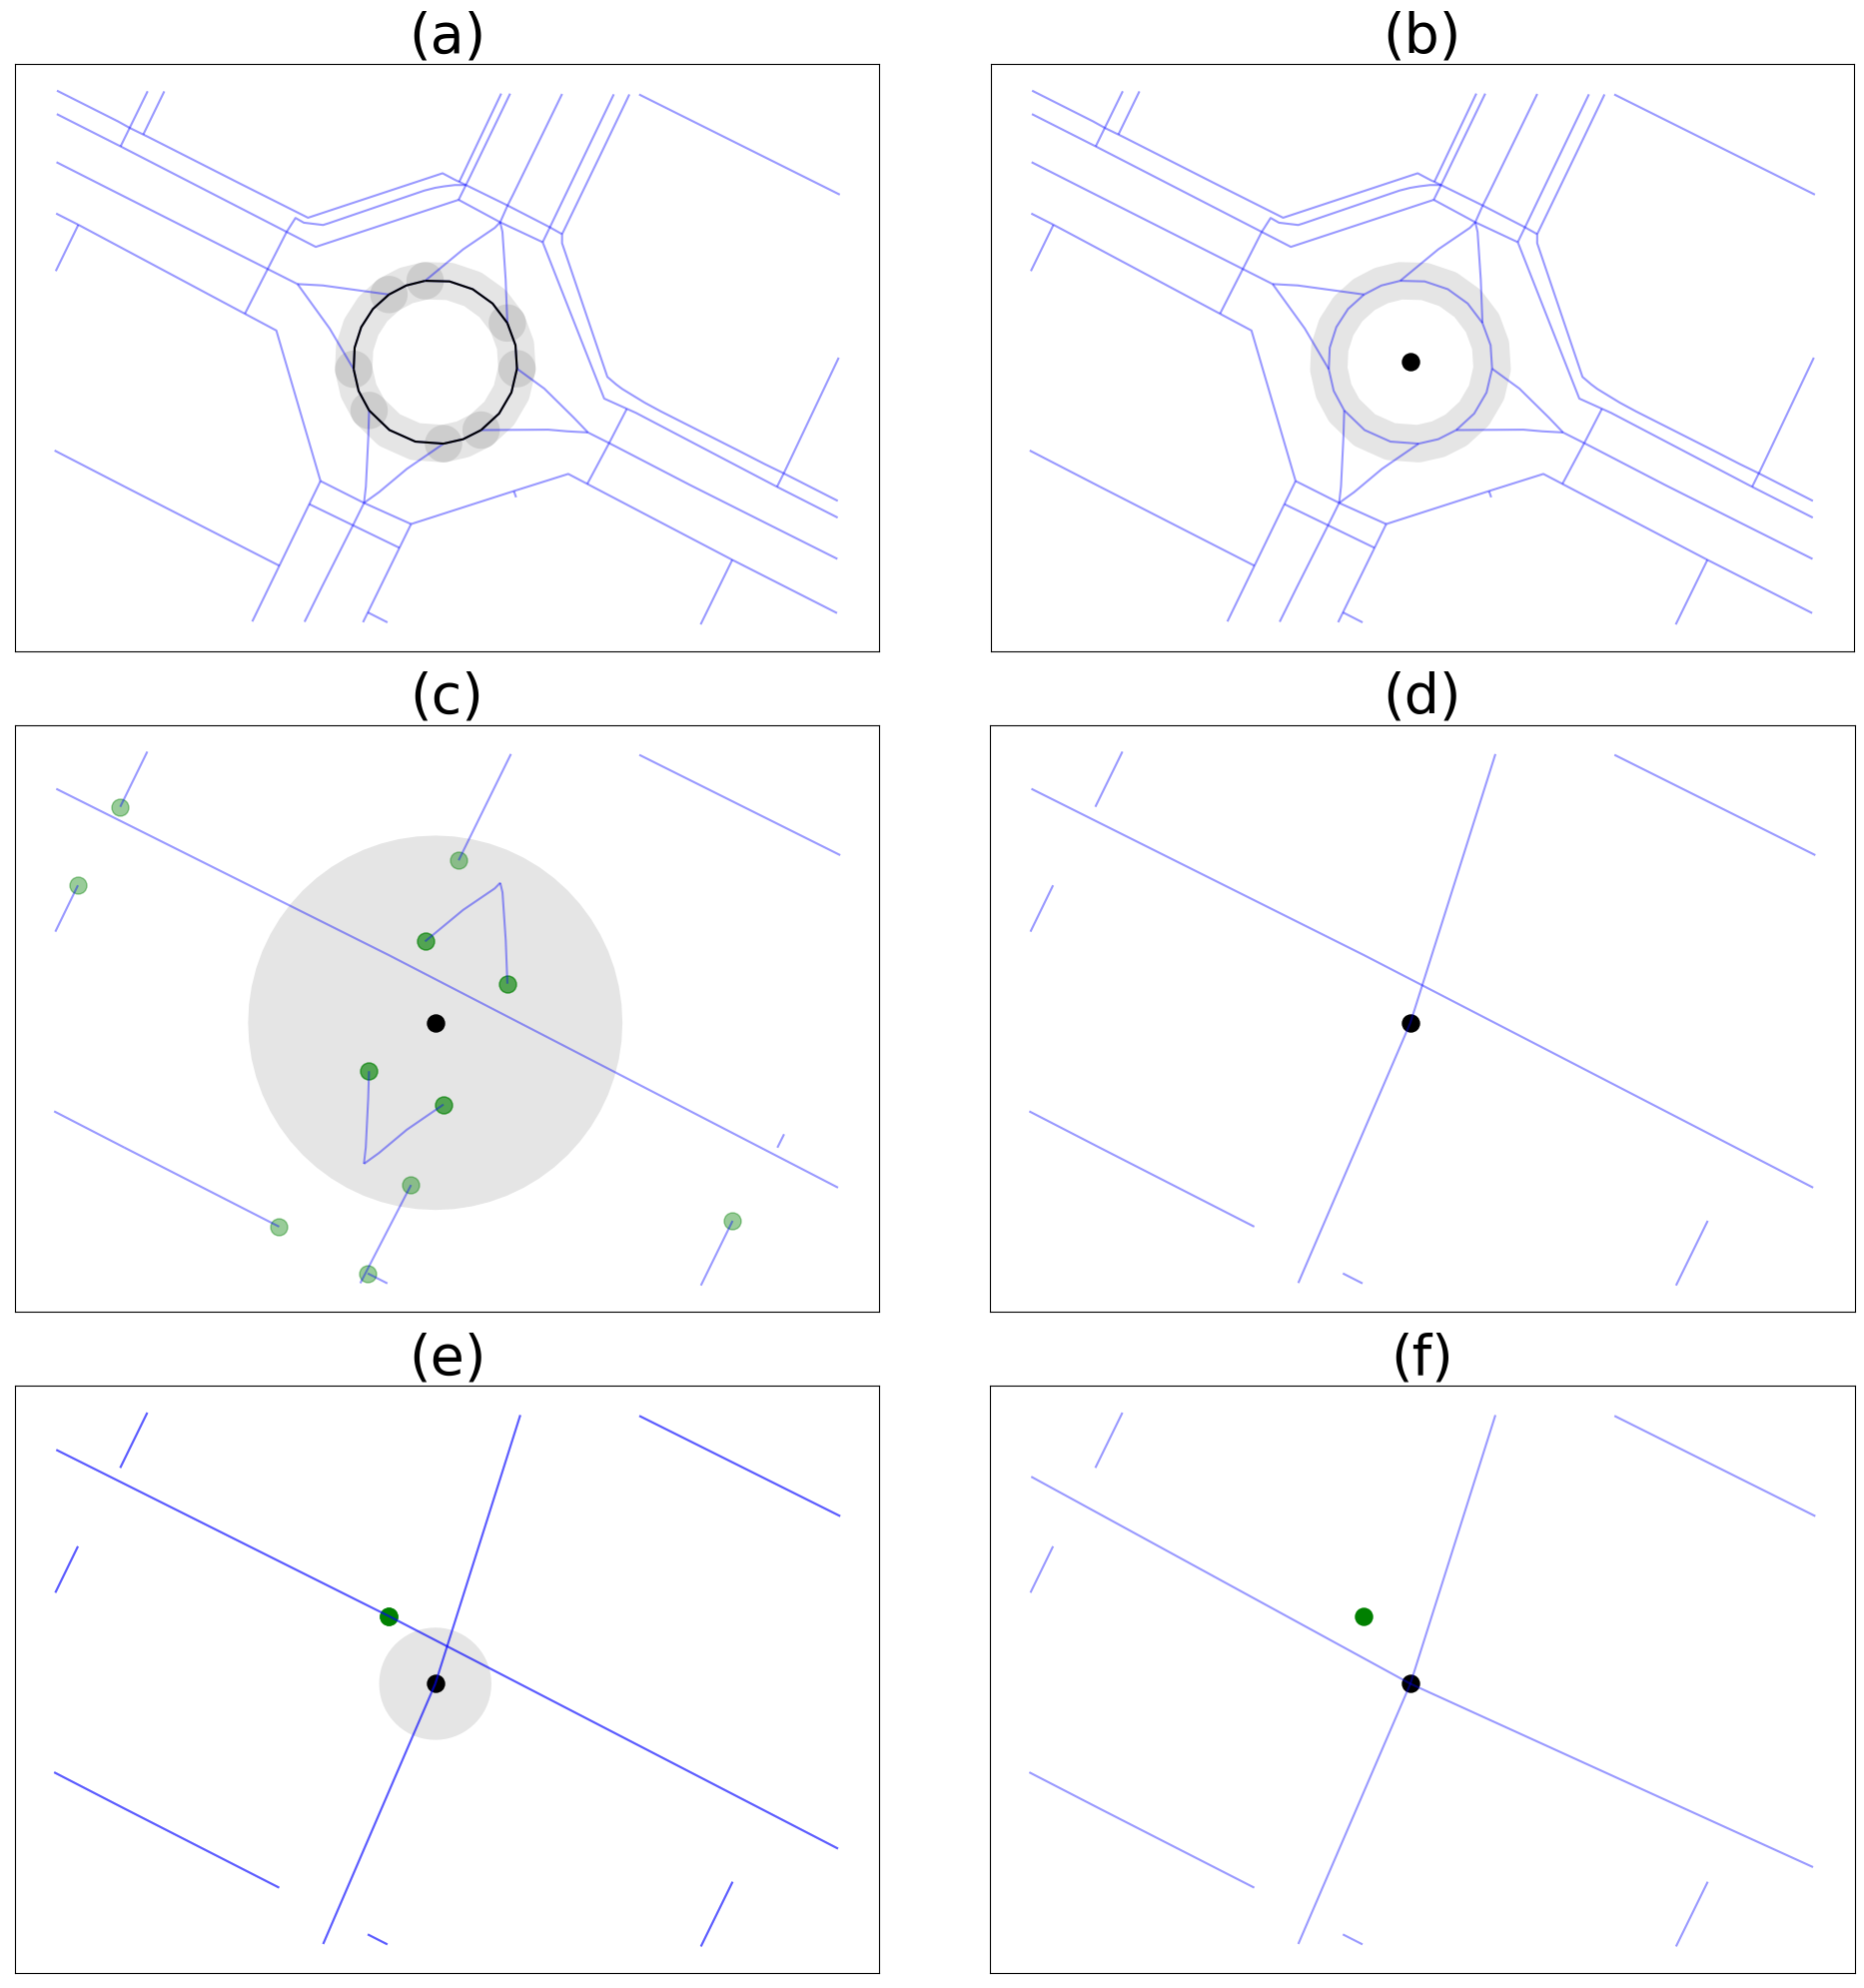

In [208]:
polygon_to_clip = gpd.read_file(f'{data_folder}/roundabout_to_analysis.shp') # example area
gdfs_to_save_micro= {}
# Clip the networks by @polygon_to_clip
for key,value in gdfs_to_save.items():
    gdfs_to_save_micro[key]= gpd.clip(value,polygon_to_clip)


fig, axs = plt.subplots(3, 2, figsize=(20,20))
road_c = 'blue'
roundabot_c= 'black'
points_c = 'green'
fontsize=40
point_size = 150
# Create a figure and four subplots
val = [f'({chr(ord("a") + i)})' for i in range(6)]
k=0

# OSM network  -a
p=0,0

clip_roundabout= gpd.clip(round_about,polygon_to_clip)
buffer_roundabout = clip_roundabout['geometry'].buffer(cap_style=1, distance=10, join_style=1)
gdfs_to_save_micro['raw_data'].plot(ax=axs[p], color=road_c, alpha=0.4)
buffer_roundabout.plot(ax=axs[p], color=roundabot_c, alpha=0.1)
clip_roundabout.plot(ax=axs[p], color=roundabot_c, alpha=1)

axs[0, 0].set_title(f'{val[k]}',fontsize=fontsize)


# No topology correction - b
k+=1
p=0,1
center = gdfs_to_save_micro['center']

gdfs_to_save_micro['raw_data'].plot(ax=axs[p], color=road_c, alpha=0.4)
center.plot(ax=axs[p],color=roundabot_c,markersize=point_size, alpha=1)
# axs[p].scatter(center.geometry.x.to_list(), center.geometry.y.to_list(), color='red', s=80)
GeoSeries(buffer_roundabout.unary_union,crs=project_crs).plot(ax=axs[p], color=roundabot_c, alpha=0.1)
axs[p].set_title(f'{val[k]}',fontsize=fontsize)

# No topology correction -c
k+=1
p=1,0
gdfs_to_save_micro['topological_correcetion'].plot(ax=axs[p], color=road_c, alpha=0.4)
center.buffer(100).plot(ax=axs[p], color=roundabot_c, alpha=0.1)
gdfs_to_save_micro['deadend_pnts'].plot(ax=axs[p], color=points_c,markersize=point_size,  alpha=0.4)
center.plot(ax=axs[p], color=roundabot_c,markersize=point_size,  alpha=1)
axs[p].set_title(f'{val[k]}',fontsize=fontsize)

# after correction 1 - d
p=1,1
k+=1


gdfs_to_save_micro['after_correction_1'].plot(ax=axs[p], color=road_c, alpha=0.4)
center.plot(ax=axs[p], color=roundabot_c,markersize=point_size,  alpha=1)
axs[p].set_title(f'{val[k]}',fontsize=fontsize)

# almost done -e
p=2,0
k+=1

# Polylines intersecting the buffer
buffer = center.buffer(30)
gdf  = gdfs_to_save['after_correction_1'].sjoin(GeoDataFrame(geometry=buffer,crs=project_crs))
# Create points layer
# Create points layer of polylines intersecting the buffer
vertices= []
gdf['geometry'].apply(lambda x:vertices.extend([Point(point[0], point[1]) for point in x.coords]))
points_df = gpd.clip(GeoDataFrame(geometry=vertices,crs=project_crs),polygon_to_clip)
points_df= points_df[~points_df['geometry'].isin(center['geometry'])]
points_df.plot(ax=axs[p], color=points_c,markersize=point_size,  alpha=1)

#  Filter out the points that do not have intersections
gdfs_to_save_micro['after_correction_1'].plot(ax=axs[p], color=road_c, alpha=0.4)

points_df.plot(ax=axs[p], color=points_c,markersize=point_size,  alpha=1)
center.plot(ax=axs[p], color=roundabot_c,markersize=point_size,  alpha=1)
buffer.plot(ax=axs[p], color=roundabot_c, alpha=0.1)
gdfs_to_save_micro['after_correction_1'].plot(ax=axs[p], color=road_c, alpha=0.4)

axs[p].set_title(f'{val[k]}',fontsize=fontsize)


# done -f
p=2,1
k+=1
final =gdfs_to_save_micro['final']
result = gpd.sjoin(points_df, final, op='intersects')
non_intersecting_points = points_df[~points_df.index.isin(result.index)]

non_intersecting_points.plot(ax=axs[p], color=points_c,markersize=point_size,  alpha=1)
final.plot(ax=axs[p], color=road_c, alpha=0.4)
center.plot(ax=axs[p], color=roundabot_c,markersize=point_size,  alpha=1)

axs[p].set_title(f'{val[k]}',fontsize=fontsize)



# Remove ticks from all subplots
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout to minimize overlapping
plt.tight_layout()
plt.savefig(f'{os.path.dirname(pjr_loc)}/versions/figs/roundabout.png')
plt.show()


In [160]:
points_df

,geometry
1,POINT (853896.759 5631888.275)


In [149]:
points_df[~points_df['geometry'].isin(center['geometry'])]

,geometry
1,POINT (853896.759 5631888.275)


In [197]:
center.geometry.x.to_list()

[853921.5350445689]